# test sim table

do some nearest/furthest neighbor tests on a given similarity table.

## imports

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
from pretty_midi import PrettyMIDI, Instrument, Note
from mido import MidiFile, MetaMessage, MidiTrack, bpm2tempo
from midi_player import MIDIPlayer
from midi_player.stylers import dark
import matplotlib.pyplot as plt

## parameters

edit these if necessary

In [2]:
# filesystem settings
dataset_name = "20240621"
table_dir = os.path.join("..", "..", "data", "tables")
table_name = f"{dataset_name}_sim.parquet"
data_dir = os.path.join("..", "..", "data", "datasets", dataset_name, "play")
output_path = os.path.join(
    "outputs", f"{datetime.now().strftime('%y%m%d-%H%M')}_{dataset_name}"
)

# test settings
num_neighbors = 5  # number of neighbors to find
exclude_same_parent = True  # only look for segments from different tracks

# random settings
seed = 9

## helper functions

In [3]:
def get_neighbors(
    table: pd.DataFrame, seed_file: str, count: int, diff_track: bool, nearest=True
):
    parent_track, segment = seed_file.split("_")
    segment = segment[:-4]

    sim_values = table.loc[seed_file].apply(lambda x: x["sim"])
    transformations = table.loc[seed_file].apply(lambda x: x["transformations"])
    top_neighbors = sim_values.nlargest(len(sim_values)).index.tolist()

    neighbors = [
        {
            "file": n,
            "sim": sim_values[n],
            "shift": transformations[n]["shift"],
            "trans": transformations[n]["transpose"],
        }
        for n in top_neighbors
    ]

    if diff_track:
        neighbors = [f for f in neighbors if f["file"].split("_")[0] != parent_track]

    neighbors.sort(key=lambda x: x["sim"], reverse=nearest)
    neighbors = neighbors[:count]

    return neighbors

In [4]:
def change_tempo(file_path: str, tempo: int):
    midi = MidiFile(file_path)
    new_tempo = bpm2tempo(tempo)
    new_message = MetaMessage("set_tempo", tempo=new_tempo, time=0)
    tempo_added = False

    for track in midi.tracks:
        # remove existing set_tempo messages
        for msg in track:
            if msg.type == "set_tempo":
                track.remove(msg)

        # add new set_tempo message to the first track
        if not tempo_added:
            track.insert(0, new_message)
            tempo_added = True

    # if no tracks had a set_tempo message and no new one was added, add a new track with the tempo message
    if not tempo_added:
        new_track = MidiTrack()
        new_track.append(new_message)
        midi.tracks.append(new_track)

    midi.save(file_path)

In [5]:
def transform(file_path: str, out_dir: str, tempo: int, transformations, num_beats: int = 8, prefix=0) -> str:
    new_filename = f"{prefix}_{Path(file_path).stem}_t{transformations["transpose"]:02d}s{transformations["shift"]:02d}"
    out_path = os.path.join(out_dir, f"{new_filename}.mid")
    MidiFile(file_path).save(out_path) # in case transpose is 0

    if transformations["transpose"] != 0:
        t_midi = PrettyMIDI(initial_tempo=tempo)

        for instrument in PrettyMIDI(out_path).instruments:
            transposed_instrument = Instrument(program=instrument.program, name=new_filename)

            for note in instrument.notes:
                transposed_instrument.notes.append(
                    Note(
                        velocity=note.velocity,
                        pitch=note.pitch + int(transformations["transpose"]),
                        start=note.start,
                        end=note.end,
                    )
                )

            t_midi.instruments.append(transposed_instrument)

        t_midi.write(out_path)

    if transformations["shift"] != 0:
        s_midi = PrettyMIDI(initial_tempo=tempo)
        seconds_per_beat = 60 / tempo
        shift_seconds = transformations["shift"] * seconds_per_beat
        loop_point = (num_beats + 1) * seconds_per_beat

        for instrument in PrettyMIDI(out_path).instruments:
            shifted_instrument = Instrument(
                program=instrument.program, name=new_filename
            )
            for note in instrument.notes:
                dur = note.end - note.start
                shifted_start = (note.start + shift_seconds) % loop_point
                shifted_end = shifted_start + dur

                if note.start + shift_seconds >= loop_point:
                    shifted_start += seconds_per_beat
                    shifted_end += seconds_per_beat

                shifted_instrument.notes.append(
                    Note(
                        velocity=note.velocity,
                        pitch=note.pitch,
                        start=shifted_start,
                        end=shifted_end
                    )
                )

            s_midi.instruments.append(shifted_instrument)

        s_midi.write(out_path)

    change_tempo(out_path, tempo)

    return out_path

In [6]:
def plot_histograms(
    histograms,
    titles,
    save_path=None,
    shape=None,
    main_title=None,
) -> None:
    plt.style.use("dark_background")

    if shape is None:
        shape = [len(histograms), 1]

    plt.figure(figsize=(12, 12))

    if main_title:
        plt.suptitle(main_title)

    for num_plot in range(len(histograms)):
        plt.subplot(shape[0], shape[1], num_plot + 1)
        plt.bar(range(12), histograms[num_plot])
        plt.xticks(
            range(12), ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
        )
        plt.title(titles[num_plot])

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    plt.close()

## setup

In [7]:
# filesystem setup
table_path = os.path.join(table_dir, table_name)
if not os.path.isdir(output_path):
    os.makedirs(output_path)
if not os.path.exists(table_path):
    print(f"unable to find table at '{table_path}'")
    FileNotFoundError

In [8]:
# load df
table = pd.read_parquet(table_path)

In [9]:
# init rng
rng = np.random.default_rng(seed)

## go

In [10]:
table.head()

,20231220-080-01_0000-0005.mid,20231220-080-01_0005-0011.mid,20231220-080-01_0011-0017.mid,20231220-080-01_0017-0023.mid,20231220-080-01_0023-0029.mid,20231220-080-01_0029-0035.mid,20231220-080-01_0035-0041.mid,20231220-080-01_0041-0047.mid,20231220-080-01_0047-0053.mid,20231220-080-01_0053-0059.mid,...,20240511-088-03_0305-0310.mid,20240511-088-03_0310-0316.mid,20240511-088-03_0316-0321.mid,20240511-088-03_0321-0327.mid,20240511-088-03_0327-0332.mid,20240511-088-03_0332-0338.mid,20240511-088-03_0338-0343.mid,20240511-088-03_0343-0349.mid,20240511-088-03_0349-0354.mid,20240511-088-03_0354-0359.mid
20231220-080-01_0000-0005.mid,"{'sim': 1.0, 'transformations': {'shift': 0, '...","{'sim': 0.99515, 'transformations': {'shift': ...","{'sim': 0.99881, 'transformations': {'shift': ...","{'sim': 0.99932, 'transformations': {'shift': ...","{'sim': 0.99909, 'transformations': {'shift': ...","{'sim': 1.0, 'transformations': {'shift': 0, '...","{'sim': 0.99851, 'transformations': {'shift': ...","{'sim': 0.9833, 'transformations': {'shift': 5...","{'sim': 0.98638, 'transformations': {'shift': ...","{'sim': 0.88912, 'transformations': {'shift': ...",...,"{'sim': 0.83656, 'transformations': {'shift': ...","{'sim': 0.83785, 'transformations': {'shift': ...","{'sim': 0.79689, 'transformations': {'shift': ...","{'sim': 0.84925, 'transformations': {'shift': ...","{'sim': 0.69472, 'transformations': {'shift': ...","{'sim': 0.59307, 'transformations': {'shift': ...","{'sim': 0.77091, 'transformations': {'shift': ...","{'sim': 0.81289, 'transformations': {'shift': ...","{'sim': 0.75184, 'transformations': {'shift': ...","{'sim': 0.69672, 'transformations': {'shift': ..."
20231220-080-01_0005-0011.mid,"{'sim': 0.99515, 'transformations': {'shift': ...","{'sim': 1.0, 'transformations': {'shift': 0, '...","{'sim': 0.98917, 'transformations': {'shift': ...","{'sim': 0.9981, 'transformations': {'shift': 4...","{'sim': 0.99844, 'transformations': {'shift': ...","{'sim': 0.99497, 'transformations': {'shift': ...","{'sim': 0.99568, 'transformations': {'shift': ...","{'sim': 0.96936, 'transformations': {'shift': ...","{'sim': 0.97685, 'transformations': {'shift': ...","{'sim': 0.90563, 'transformations': {'shift': ...",...,"{'sim': 0.85662, 'transformations': {'shift': ...","{'sim': 0.85204, 'transformations': {'shift': ...","{'sim': 0.805, 'transformations': {'shift': 2,...","{'sim': 0.86616, 'transformations': {'shift': ...","{'sim': 0.69896, 'transformations': {'shift': ...","{'sim': 0.62713, 'transformations': {'shift': ...","{'sim': 0.81394, 'transformations': {'shift': ...","{'sim': 0.84797, 'transformations': {'shift': ...","{'sim': 0.78744, 'transformations': {'shift': ...","{'sim': 0.73044, 'transformations': {'shift': ..."
20231220-080-01_0011-0017.mid,"{'sim': 0.99871, 'transformations': {'shift': ...","{'sim': 0.98889, 'transformations': {'shift': ...","{'sim': 1.0, 'transformations': {'shift': 0, '...","{'sim': 0.99617, 'transformations': {'shift': ...","{'sim': 0.99564, 'transformations': {'shift': ...","{'sim': 0.99881, 'transformations': {'shift': ...","{'sim': 0.99619, 'transformations': {'shift': ...","{'sim': 0.98677, 'transformations': {'shift': ...","{'sim': 0.98756, 'transformations': {'shift': ...","{'sim': 0.87725, 'transformations': {'shift': ...",...,"{'sim': 0.82305, 'transformations': {'shift': ...","{'sim': 0.82735, 'transformations': {'shift': ...","{'sim': 0.7897, 'transformations': {'shift': 2...","{'sim': 0.83731, 'transformations': {'shift': ...","{'sim': 0.6899, 'transformations': {'shift': 2...","{'sim': 0.57326, 'transformations': {'shift': ...","{'sim': 0.7458, 'transformations': {'shift': 5...","{'sim': 0.79172, 'transformations': {'shift': ...","{'sim': 0.73063, 'transformations': {'shift': ...","{'sim': 0.67669, 'transformations': {'shift': ..."
20231220-080-01_0017-0023.mid,"{'sim': 0.99932, 'transformations': {'shift': ...","{'sim': 0.9981, 'transformations': {'shift': 5...","{'sim': 0.99634, 'transformations': {'

### nearest neighbors

In [11]:
seed_file = rng.choice(table.columns)
print(f"finding nearest neighbors to '{seed_file}'")

neighbors = get_neighbors(table, seed_file, num_neighbors, exclude_same_parent, True)

# transform and copy nearest neighbors
for i, neighbor in enumerate(neighbors):
    print(
        f"'{neighbor['file']}' has similarity {neighbor['sim']:.03f} with the transformations: [s: {neighbor['shift']:02d}, t: {neighbor['trans']:02d}]"
    )

    # transform
    tempo = int(neighbor["file"].split("-")[1])
    new_filename = transform(
        os.path.join(data_dir, neighbor["file"]),
        output_path,
        tempo,
        {"shift": neighbor["shift"], "transpose": neighbor["trans"]},
        prefix=f"n{i+1}",
    )
    neighbors[i]["file"] = new_filename

# copy over seed file
MidiFile(os.path.join(data_dir, seed_file)).save(
    os.path.join(output_path, f"s_{seed_file}")
)
neighbors.insert(0, {"file": os.path.join(output_path, f"s_{seed_file}")})

finding nearest neighbors to '20240124-064-02_0119-0127.mid'
'20240227-076-01_0202-0208.mid' has similarity 0.996 with the transformations: [s: 06, t: 11]
transforming '20240227-076-01_0202-0208' {'shift': 6, 'transpose': 11}
'20240227-076-01_0189-0195.mid' has similarity 0.993 with the transformations: [s: 06, t: 11]
transforming '20240227-076-01_0189-0195' {'shift': 6, 'transpose': 11}
'20240227-076-01_0271-0277.mid' has similarity 0.992 with the transformations: [s: 06, t: 11]
transforming '20240227-076-01_0271-0277' {'shift': 6, 'transpose': 11}
'20240227-076-01_0214-0220.mid' has similarity 0.990 with the transformations: [s: 06, t: 11]
transforming '20240227-076-01_0214-0220' {'shift': 6, 'transpose': 11}
'20240305-050-02_0172-0182.mid' has similarity 0.990 with the transformations: [s: 03, t: 09]
transforming '20240305-050-02_0172-0182' {'shift': 3, 'transpose': 9}


#### listen to the nearest neighbors

In [12]:
MIDIPlayer(neighbors[0]["file"], 300, styler=dark, title=f"{Path(neighbors[0]["file"]).stem}.mid")

In [13]:
MIDIPlayer(neighbors[1]["file"], 300, styler=dark, title=f"{Path(neighbors[1]["file"]).stem}.mid")

In [14]:
MIDIPlayer(neighbors[2]["file"], 300, styler=dark, title=f"{Path(neighbors[2]["file"]).stem}.mid")

In [15]:
MIDIPlayer(neighbors[3]["file"], 300, styler=dark, title=f"{Path(neighbors[3]["file"]).stem}.mid")

In [16]:
MIDIPlayer(neighbors[4]["file"], 300, styler=dark, title=f"{Path(neighbors[4]["file"]).stem}.mid")

In [17]:
MIDIPlayer(neighbors[5]["file"], 300, styler=dark, title=f"{Path(neighbors[5]["file"]).stem}.mid")

#### view pitch histograms

(assuming thats relevant for the metric)

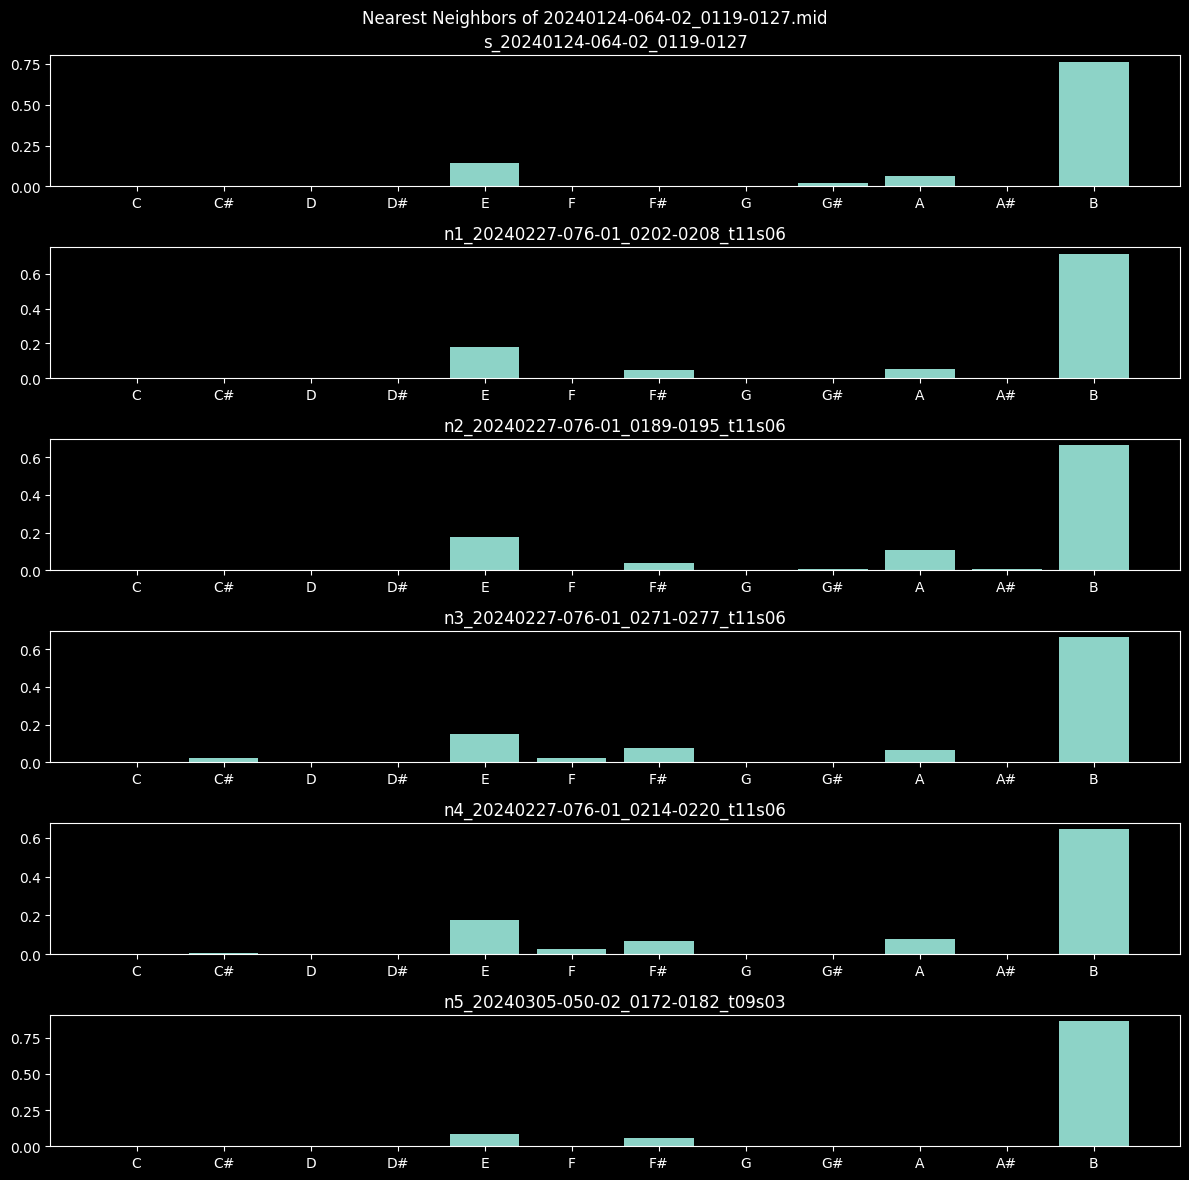

In [18]:
get_hist = lambda x: PrettyMIDI(x).get_pitch_class_histogram(True, True)
plot_histograms(
    [get_hist(n["file"]) for n in neighbors],
    [Path(n["file"]).stem for n in neighbors],
    os.path.join(output_path, "nearest_phs.jpg"),
    main_title=f"Nearest Neighbors of {seed_file}",
)

### furthest neighbors

In [19]:
print(f"finding furthest neighbors from '{seed_file}'")

neighbors = get_neighbors(table, seed_file, num_neighbors, exclude_same_parent, False)

# transform and copy nearest neighbors
for i, neighbor in enumerate(neighbors):
    print(
        f"'{neighbor['file']}' has similarity {neighbor['sim']:.03f} with the transformations: [s: {neighbor['shift']:02d}, t: {neighbor['trans']:02d}]"
    )
    tempo = int(neighbor["file"].split("-")[1])
    new_filename = transform(
        os.path.join(data_dir, neighbor["file"]),
        output_path,
        tempo,
        {"shift": neighbor["shift"], "transpose": neighbor["trans"]},
        prefix=f"f{i + 1}",
    )
    neighbors[i]["file"] = new_filename

neighbors.insert(0, {"file": os.path.join(output_path, f"s_{seed_file}")})

finding furthest neighbors from '20240124-064-02_0119-0127.mid'
'20240305-050-09_0095-0105.mid' has similarity 0.473 with the transformations: [s: 03, t: 08]
transforming '20240305-050-09_0095-0105' {'shift': 3, 'transpose': 8}
'20240123-070-07_0425-0431.mid' has similarity 0.479 with the transformations: [s: 03, t: 09]
transforming '20240123-070-07_0425-0431' {'shift': 3, 'transpose': 9}
'20240123-070-07_0431-0438.mid' has similarity 0.480 with the transformations: [s: 03, t: 09]
transforming '20240123-070-07_0431-0438' {'shift': 3, 'transpose': 9}
'20240305-050-09_0028-0038.mid' has similarity 0.482 with the transformations: [s: 06, t: 11]
transforming '20240305-050-09_0028-0038' {'shift': 6, 'transpose': 11}
'20240121-070-02_0740-0747.mid' has similarity 0.490 with the transformations: [s: 00, t: 03]
transforming '20240121-070-02_0740-0747' {'shift': 0, 'transpose': 3}


#### listen to the furthest neighbors

note that this doesn't *quite* work because its still taking the best possible set of transformations for each file, it's just using the file that has the worst match.

In [20]:
MIDIPlayer(neighbors[0]["file"], 300, styler=dark, title=f"{Path(neighbors[0]["file"]).stem}.mid")

In [21]:
MIDIPlayer(neighbors[1]["file"], 300, styler=dark, title=f"{Path(neighbors[1]["file"]).stem}.mid")

In [22]:
MIDIPlayer(neighbors[2]["file"], 300, styler=dark, title=f"{Path(neighbors[2]["file"]).stem}.mid")

In [23]:
MIDIPlayer(neighbors[3]["file"], 300, styler=dark, title=f"{Path(neighbors[3]["file"]).stem}.mid")

In [24]:
MIDIPlayer(neighbors[4]["file"], 300, styler=dark, title=f"{Path(neighbors[4]["file"]).stem}.mid")

In [25]:
MIDIPlayer(neighbors[5]["file"], 300, styler=dark, title=f"{Path(neighbors[5]["file"]).stem}.mid")

#### view pitch histograms

(assuming thats relevant for the metric)

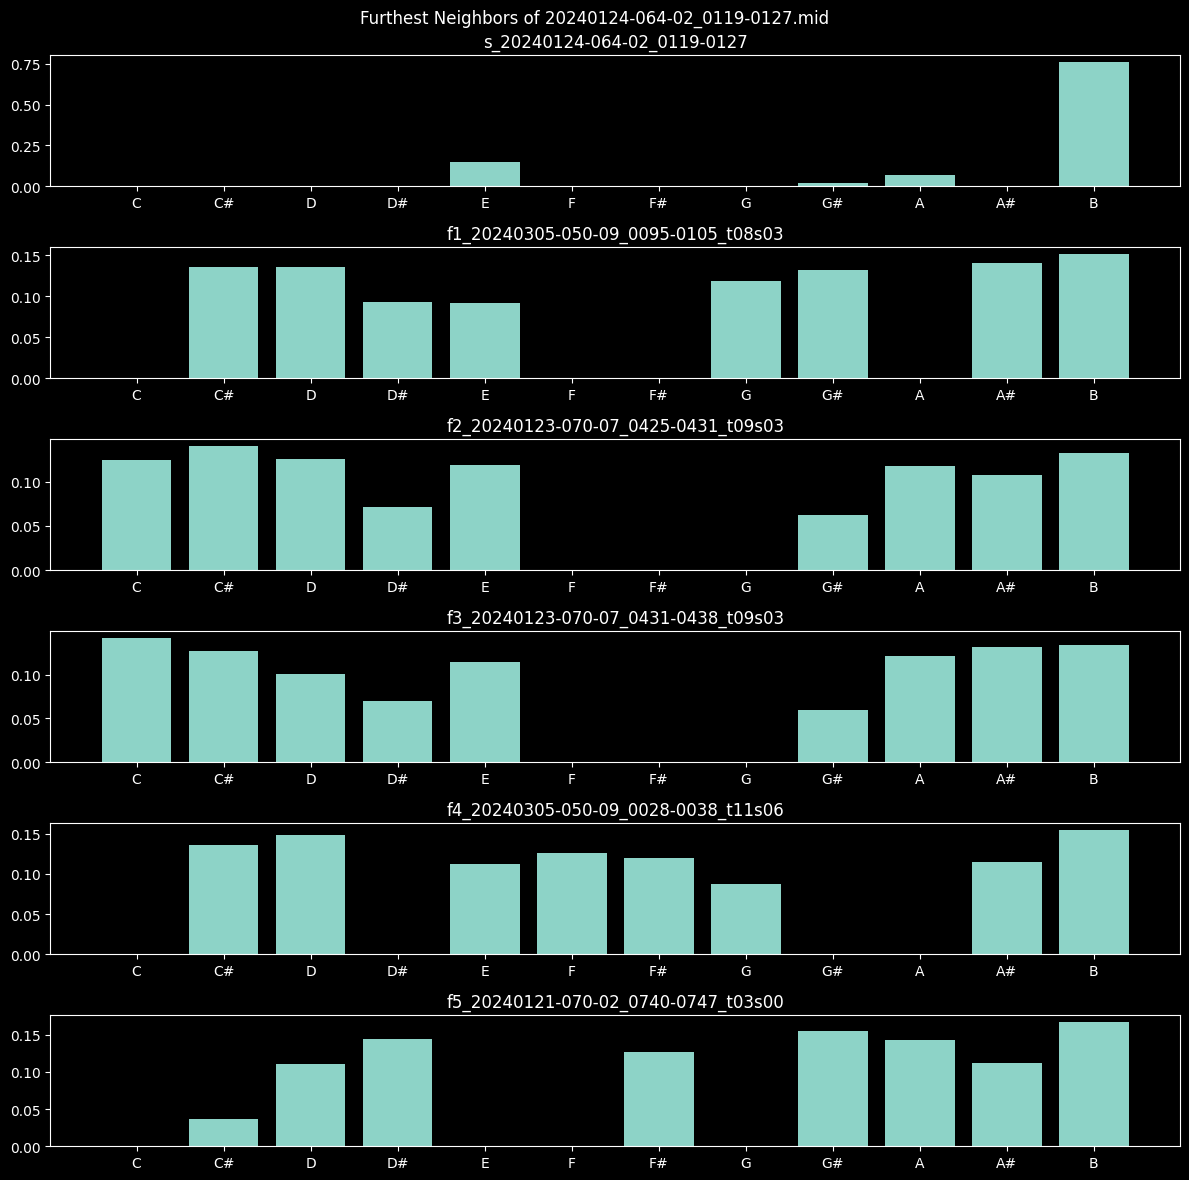

In [26]:
get_hist = lambda x: PrettyMIDI(x).get_pitch_class_histogram(True, True)
plot_histograms(
    [get_hist(n["file"]) for n in neighbors],
    [Path(n["file"]).stem for n in neighbors],
    os.path.join(output_path, "furthest_phs.jpg"),
    main_title=f"Furthest Neighbors of {seed_file}",
)